In [121]:
from preprocessor import DataSampleGenerator
from preprocessor import FeatureGenerator
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy import signal

sosHigh = signal.butter(10, 1, 'hp', fs=256, output='sos')
sosLow = signal.butter(10, 90, 'lp', fs=256, output='sos')

# ~~~~ SAMPLE CODE ~~~~

# Hz
offset = 0
# Hz
samplingRate = 256
# seconds
timeSegmentLen = 3
# overlap
overlap = 2
# seconds
labelSegmentLen = 4
# Hz
startCutoff = 126
endCutoff = 126

# Get the data from the matlab file
data = loadmat('data/BP_2019PP1.mat')['data'].T
# EEG data in following format: 
#   cols = samples, rows = channels
#   channels 6 and 7 contain bad data, so we ignore those
    
eeg = data[:6,:]
for i, sig in enumerate(eeg):
    mean_removed = np.ones_like(sig)*np.mean(sig)
    sig = sig - mean_removed
    sig = signal.sosfilt(sosHigh, sig)
    eeg[i] = signal.sosfilt(sosLow, sig)
# Last 4 channels are the label channels
labels = data[8:12,:]

# Set up the sample generator:
#   samplingRate    : The current data file has a sampling rate of 256 Hz
#   timeSegmentLen  : We want to generate labeled samples of 3 seconds long
#   overlap         : We want to overlap each sample for two seconds
#   labelSegmentLen : The amount of seconds of data each corresponding to a label
#   startCutoff     : Amount of samples to ignore at the start of each labelSegment
#   endCutoff       : Amount of samples to ignore at the end of each labelSegment  
sampleGenerator = DataSampleGenerator(eeg, labels, samplingRate, timeSegmentLen, overlap,
                                        labelSegmentLen, startCutoff, endCutoff)

In [122]:
samples = {0: [], 1: [], 2: [], 3: []}
for sample, label in sampleGenerator:  
    samples[label].append(sample)

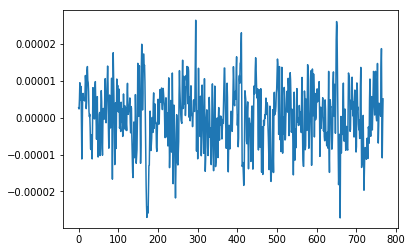

In [123]:
plt.plot(samples[0][5][0])
plt.show()

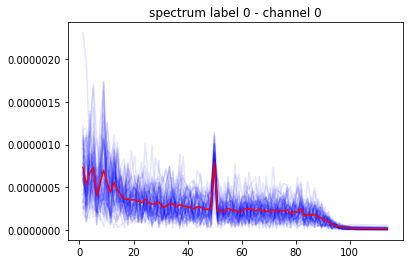

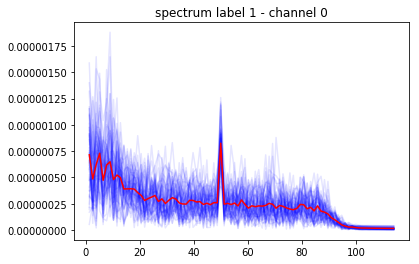

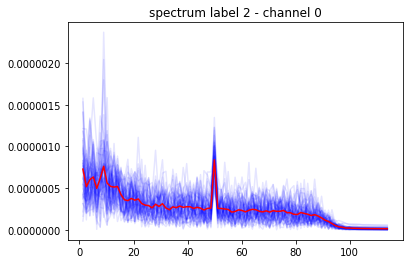

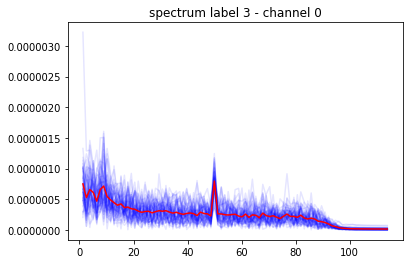

In [128]:
import scipy.fftpack
import numpy as np3

channel = 0

for i in range(4):
    signal_avg = np.zeros((200,))
    for sample in samples[i]:
        y = sample[channel]
        N = y.shape[0]           # Number of samplepoints
        Fs = samplingRate
        T = 1.0 / Fs      # N_samps*T (#samples x sample period) is the sample spacing.
        N_fft = 200        # Number of bins (chooses granularity)
        x = np.linspace(0, N*T, N)     # the interval

        yf = scipy.fftpack.fft(y,n=N_fft)
        xf = np.arange(0,Fs,Fs/N_fft)
        plt.plot(xf[1:90], 2.0/N * np.abs(yf[0:N//2])[1:90],alpha=0.1, c='blue')
        signal_avg += 2.0/N * np.abs(yf[0:N//2])
    signal_avg /= len(samples[i])
    plt.title(f'spectrum label {i} - channel {channel}')
    plt.plot(xf[1:90], signal_avg[1:90], c='red')
    plt.show()

